This notebook lays out some simulations that examine the effects of crossvalidation schemes in the context
of regression models.  The code for these simulations is available at https://github.com/poldrack/regressioncv. This version is a simplification of the previous version of code there, which was discussed in my blog post: http://www.russpoldrack.org/2012/12/the-perils-of-leave-one-out.html

First, we import the necessary functions:

In [1]:
import numpy,pandas
import seaborn
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from statsmodels.regression.linear_model import OLS

import matplotlib.pyplot as plt
%matplotlib inline

# this imports a function to do balanced cross validation
from get_balanced_folds import BalancedKFold

This function will perform a single run of the simulation, creating a random dataset and estimating predictive performance using several different cross-validation methods:

- Leave-one-out
- Split-half (i.e. K-fold where K=2) 
- Split-hanf using balanced cross validation, which tries to equate the distributions of Y values across the different folds.


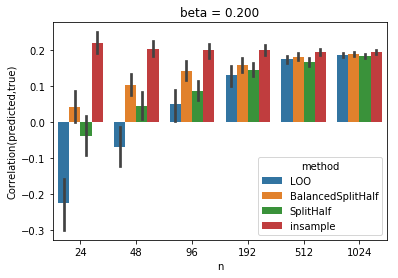

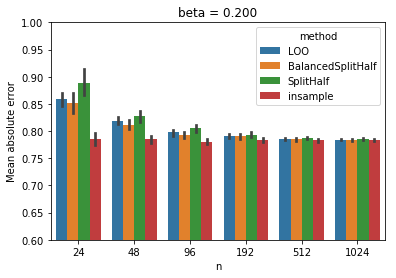

In [2]:
def cvtest(nsubs,cv_fns=None,beta=0.2,
           scale_X=True,scale_Y=True):
    """
    - function to perform a single simulation run
    nsubs: number of subjects per simulation
    cv_fns: dict of CV functions
    beta: strength of true relationship
    measure: 'corr': correlation, 'MAE': mean absolute error
    """
    results_corr=[]
    results_mae=[]
    
    if cv_fns is None:
        cv_fns={'LOO':model_selection.LeaveOneOut(),
               'BalancedSplitHalf':BalancedKFold(nfolds=2,pthresh=0.99),
               'SplitHalf':model_selection.KFold(n_splits=2,shuffle=True)}

    # just use simple linear regression
    clf=LinearRegression()
    
    # create random X and Y variables
    X=numpy.random.randn(nsubs).reshape((nsubs,1))
    Y=numpy.random.randn(nsubs).reshape((nsubs,1)) + X*beta
    if scale_X:
        X = (X - numpy.mean(X))/numpy.std(X)
    if scale_Y:
        Y = (Y - numpy.mean(Y))/numpy.std(Y)

    # first run leave-one-out CV
    for method in cv_fns:
        cv=cv_fns[method]
        pred=numpy.zeros(nsubs)
        for train_index, test_index in cv.split(X,Y):            
            X_train, X_test = X[train_index,:], X[test_index,:]
            y_train, y_test = Y[train_index], Y[test_index]

            clf.fit(X_train,y_train)
            pred[test_index]=clf.predict(X_test)
        corr=numpy.corrcoef(pred,Y[:,0])[0,1]
        MAE=numpy.mean(numpy.abs(pred-Y[:,0]))
        results_corr.append([method,corr])
        results_mae.append([method,MAE])
    # also include in-sample
    clf.fit(X,Y)
    pred=clf.predict(X)
    corr=numpy.corrcoef(pred,Y[:,0])[0,1]
    MAE=numpy.mean(numpy.abs(pred-Y[:,0]))
    results_corr.append(['insample',corr])
    results_mae.append(['insample',MAE])
    return(results_corr,results_mae)
    
def plot_results(results,beta,measure):
    plt.figure()
    results_df = pandas.DataFrame(results,columns=['n','method',measure])
    seaborn.barplot(x='n',y=measure,hue='method',data=results_df)
    plt.title('beta = %0.3f'%beta)
    if measure=='MAE':
        plt.ylim((0.6,1.0))
        plt.ylabel('Mean absolute error')
    elif measure=='corr':
        plt.ylabel('Correlation(predicted,true)')
 

def run_sim(nruns,beta):
    results_corr=[]
    results_mae=[]
    for n in [24,48,96,192,512,1024]:
        for run in range(nruns):
            result_corr,result_mae=cvtest(n,beta=beta)
            for r in result_corr:
                results_corr.append([n]+r)
            for r in result_mae:
                results_mae.append([n]+r)
                
    return(results_corr,results_mae)

beta=.2
results_corr,results_mae=run_sim(nruns=100,beta=beta)
plot_results(results_corr,beta,'corr')
plot_results(results_mae,beta,'MAE')



When using correlation between predicted and actual values as our measure of peformance (top plot), we see that leave-one-out is systematically biased in the negative direction, especially at small sample sizes.  Split-half is biased to a lesser extent, and balanced split-half performs better, again seen mostly at smaller sample sizes.  At sample sizes of 512 and above, all of the crossvalidation methods are roughly equivalent, each showing a slight degrement compared to in-sample results (i.e. "shrinkage"). 

This problem does not occur when using mean absolute error as the performance measure (bottom plot).  In that case, split half performs poorly compared to LOO and balanced split-half which are roughly equivalent.

Now let's see what it looks like when there is no true signal (beta=0). 

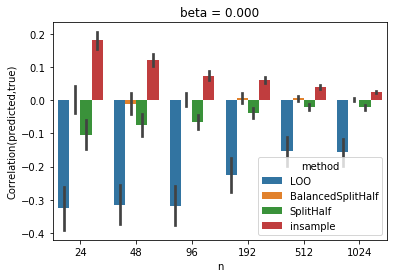

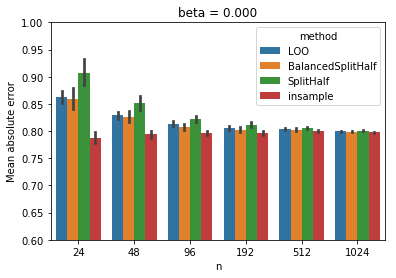

In [3]:
beta=0.
results_corr,results_mae=run_sim(nruns=100,beta=beta)
plot_results(results_corr,beta,'corr')
plot_results(results_mae,beta,'MAE')



Here we see that leave-one-out is badly biased in the negative direction, whereas in-sample prediction is biased in the positive direction.  Balanced split-half is the only method is consistently unbiased across all sample sizes.

Now let's illustrate where this comes from. First we will generate some random X and Y variables with a moderate correlation.

cor(X,Y): 0.272868447702


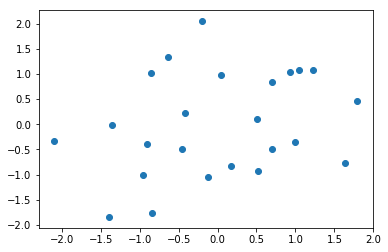

In [4]:
good_data=False
nsubs=24
beta=0.3
numpy.random.seed(123456)
X=numpy.random.randn(nsubs).reshape(nsubs,1)
Y=numpy.random.randn(nsubs).reshape(nsubs,1) + X*beta

Y = (Y - numpy.mean(Y))/numpy.std(Y)
X = (X - numpy.mean(X))/numpy.std(X)

print('cor(X,Y):',numpy.corrcoef(X[:,0],Y[:,0])[0,1])
plt.scatter(X,Y)

Let's first compute the linear relation using the full dataset.

In [5]:
lm_full=LinearRegression()
lm_full.fit(X,Y)
print(lm_full.coef_)

[ 0.27286845]


Now let's do leave-one-out crossvalidation and see what happens to the predicted regression coefficient on each fold.

In [6]:
cv=model_selection.LeaveOneOut()
pred=numpy.zeros(X.shape[0])
coef=numpy.zeros(X.shape[0])

for train_index, test_index in cv.split(X,Y):            
    X_train, X_test = X[train_index,:], X[test_index,:]
    y_train, y_test = Y[train_index,0], Y[test_index,0]
    lm_full.fit(X_train,y_train)
    pred[test_index]=lm_full.predict(X_test)
    coef[test_index]=lm_full.coef_[0]
error=pred-Y.T

In [7]:
numpy.corrcoef(pred,Y.T)

array([[ 1.        ,  0.00906506],
       [ 0.00906506,  1.        ]])

As expected, the out-of-sample prediction accuracy is basically zero.

Now let's plot the relationship between the predicted and actual values see if we can get any insight.

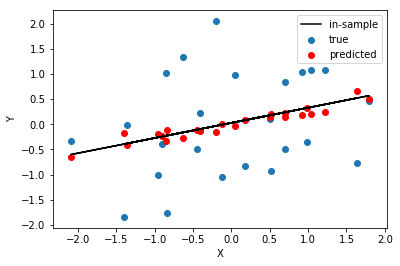

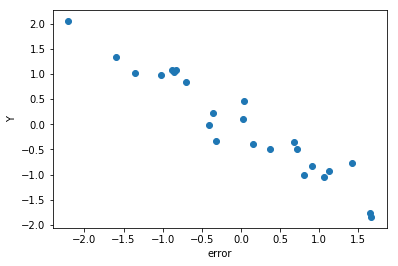

In [8]:

plt.scatter(X,Y,label='true')
plt.scatter(X,pred,color='r',label='predicted')
x = numpy.array([min(X),max(X)])
plt.plot(X,lm_full.predict(X), c="black", label="in-sample")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

#for i in range(len(X)):
plt.figure()
plt.scatter(error,Y)
plt.xlabel('error')
plt.ylabel('Y')


There is a strong negative relationship between error and Y value - large positive Y values show large negative errors, and large negative Y values show large positive errors.  This reflects the fact that when a large positive Y value is left out, the regression line will shift in the other direction.